In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyLDAvis
import random
import scipy.sparse
import sys
import time

from gensim.models.coherencemodel import CoherenceModel
from pyspark import SparkContext
from pyspark.sql import SparkSession
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

/home/olam/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """
    def __init__(self, data, S):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}
        self.doc2bow = S

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))

In [3]:
conf = SparkConf().setMaster("local").setAll([
     ('spark.executor.memory', '8g'),
     ('spark.driver.memory','8g'),
     ('spark.driver.maxResultSize', '0')
    ])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

/home/olam/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:75: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [5]:
# Load data
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/view10000_sub100000/csr_matrices_100000sub/S_final_tok100vid.npz')

# Load set of videos to consider
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/sorted_idx_relevant_vid_top20_sub100000.pickle', 'rb') as f:
    sorted_idx_relevant_vid_top20 = pickle.load(f)
f.close()

S_20 = S[sorted_idx_relevant_vid_top20,:]
S_20 = remove_zero_rows(S_20)

In [6]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/id2word_tok100vid_sub100000.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/describe_topics_75_iter1000_tok100vid.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

## Computing c_v coherence of a topic model

In [ ]:
topics = []

for row in describe_topics.sort('topic').rdd.collect():
    tokenized_topic = []
    for i, token_id in enumerate(row.termIndices):
        tokenized_topic.append(id2word[token_id])
        if i > 5:
            break
    topics.append(tokenized_topic)

In [ ]:
describe_topics = describe_topics.sort('topic')

In [ ]:
vocabSize = S_20.shape[1]

In [ ]:
topic_word_dist = []

for row in describe_topics.collect():
    termIndices = row['termIndices']
    termWeights = row['termWeights']
    
    word_dist = {}
    for i in range(vocabSize):
        word_dist[termIndices[i]] = termWeights[i]
        
    word_dist_ordered = collections.OrderedDict(sorted(word_dist.items()))
    topic_word_dist.append(list(word_dist_ordered.values()))

In [ ]:
topic_word_dist = np.matrix(topic_word_dist)

In [ ]:
vocab = list(id2word.values())

In [ ]:
vocab = np.array(vocab)

In [ ]:
texts = []

In [ ]:
for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [ ]:
topic_word_dist.shape

In [ ]:
coherence_score = metric_coherence_gensim(measure='c_v',
                                          topic_word_distrib=topic_word_dist,
                                          vocab=vocab,
                                          texts=texts)

In [ ]:
coherence_model = CoherenceModel(topics=topics,
                                 corpus=S_20,
                                 dictionary=FakedGensimDict.from_vocab(vocab),
                                 texts=texts,
                                 coherence='c_v')

In [ ]:
coherence_model.get_coherence() ## with 5 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 10 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 20 words to describe topics

## Get coherence scores from multiple models to choose optimal number of topics

In [7]:
texts = []

for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [8]:
corpus = []

for row in S_20.toarray():
    bow = []
    idx_nonzero = np.nonzero(row)[0]
    for i in range(len(idx_nonzero)):
        bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
    corpus.append(bow)

In [44]:
coherence_scores = []
coherence_scores_umass = []

n_topics_list = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 
                 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160]

for i, n_topics in enumerate(n_topics_list):
    
    print('Computing coherence score for model with ' + str(n_topics) + ' topics...')
    
    # Get describe_topics dataframe
    describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/tune/describe_topics_' + str(n_topics) + '_iter1000_tok100vid.json')
    
    
    # Characterize the topics with tokens
    topics = []

    for row in describe_topics.sort('topic').rdd.collect():
        tokenized_topic = []
        for j, token_id in enumerate(row.termIndices):
            tokenized_topic.append(id2word[token_id])
            if j > 10:
                break
        topics.append(tokenized_topic)
        
    # Compute c_v coherence score and append to coherence scores
    coherence_model = CoherenceModel(topics=topics,
                                     corpus=S_20,
                                     dictionary=FakedGensimDict(id2word, S_20),
                                     texts=texts,
                                     coherence='c_v')
    
    # Compute u_mass coherence score and append to coherence scores
    coherence_model_umass = CoherenceModel(topics=topics,
                                     corpus=corpus,
                                     dictionary=FakedGensimDict(id2word, S_20),
                                     coherence='u_mass')
     
    print('Getting c_v coherence score...')
    coherence_scores.append(coherence_model.get_coherence())
    print('Getting u_mass coherence score...')
    coherence_scores_umass.append(coherence_model_umass.get_coherence())
    print('')

Computing coherence score for model with 40 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 45 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 50 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 55 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 60 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 65 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 70 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 75 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with

([<matplotlib.axis.XTick at 0x7fdacc6dd310>,
 [Text(0, 0, '40'),
  Text(1, 0, '45'),
  Text(2, 0, '50'),
  Text(3, 0, '55'),
  Text(4, 0, '60'),
  Text(5, 0, '65'),
  Text(6, 0, '70'),
  Text(7, 0, '75'),
  Text(8, 0, '80'),
  Text(9, 0, '85'),
  Text(10, 0, '90'),
  Text(11, 0, '95'),
  Text(12, 0, '100'),
  Text(13, 0, '105'),
  Text(14, 0, '110'),
  Text(15, 0, '115'),
  Text(16, 0, '120'),
  Text(17, 0, '125'),
  Text(18, 0, '130'),
  Text(19, 0, '135'),
  Text(20, 0, '140'),
  Text(21, 0, '145'),
  Text(22, 0, '150'),
  Text(23, 0, '155'),
  Text(24, 0, '160')])

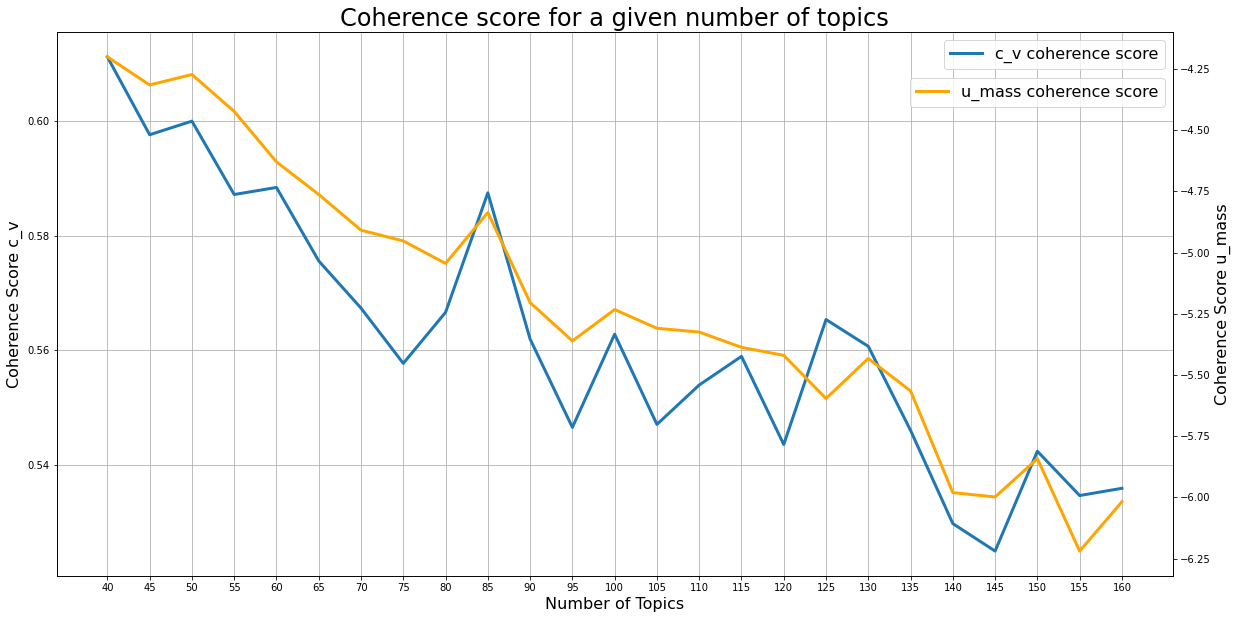

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Coherence score for a given number of topics', fontsize=24)
ax.set_xlabel('Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score c_v', fontsize=16)

ax.grid('on')

ax.plot(coherence_scores, label='c_v coherence score', linewidth=3)

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score u_mass', fontsize=16)
ax2.plot(coherence_scores_umass, label='u_mass coherence score', linewidth=3, color='orange')

ax.legend(fontsize=16)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93), fontsize=16)

plt.xticks(np.arange(len(n_topics_list)), n_topics_list)

In [46]:
fig.savefig('/home/olam/coherence_scores')

# Get insights with k = 85 and k = 125

- pic with the c_v and u_mass curve at number of topics k = 85 and k = 125
- now, check manually that the topics are meaningful

In [47]:
describe_topics_85 = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/tune/describe_topics_85_iter1000_tok100vid.json')

In [48]:
# Print topics
for row in describe_topics_85.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.02626549058985871 : history
   With weight of 0.021446678262269 : war
   With weight of 0.01717959757276261 : army
   With weight of 0.014523209416752437 : military
   With weight of 0.01304192850941908 : honor
   With weight of 0.01289715490593907 : world
   With weight of 0.011545984497304014 : united
   With weight of 0.011457708193813096 : alien
   With weight of 0.011323723257712817 : great
   With weight of 0.01120440628786251 : russia
   With weight of 0.010366911241504698 : usa
Topic 1: 
   With weight of 0.13136438169339318 : watch
   With weight of 0.03731305334050921 : indonesia
   With weight of 0.030861286235410547 : dogs
   With weight of 0.028839991205313036 : lady
   With weight of 0.02492424322358611 : must
   With weight of 0.022250933110418956 : net
   With weight of 0.020453101076611028 : million
   With weight of 0.015892597056640402 : welcome
   With weight of 0.01390691856550457 : malaysia
   With weight of 0.012664707242115762 : act

In [49]:
describe_topics_125 = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/tune/describe_topics_125_iter1000_tok100vid.json')

In [50]:
# Print topics
for row in describe_topics_125.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.07426101041616116 : rap
   With weight of 0.06029611168422842 : hip
   With weight of 0.059323101347740825 : hop
   With weight of 0.03997675290798728 : like
   With weight of 0.02780247421515313 : lil
   With weight of 0.017848601652196493 : music
   With weight of 0.014231536026374125 : freestyle
   With weight of 0.012382663242117582 : video
   With weight of 0.010387847416775765 : hiphop
   With weight of 0.010332276787997481 : rich
   With weight of 0.010232276367105313 : jay
Topic 1: 
   With weight of 0.19006140217582096 : nba
   With weight of 0.14215418287319403 : team
   With weight of 0.07206513903862105 : chris
   With weight of 0.04184529926062805 : 2k16
   With weight of 0.03781769720548135 : 2k15
   With weight of 0.03728754945650714 : change
   With weight of 0.03270747468295648 : 2k14
   With weight of 0.025062351225367516 : 2k17
   With weight of 0.024700926877118848 : career
   With weight of 0.02117682943064886 : gameplay
   With weight